# Importing libraries and reading in file

In [16]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.ml.classification import LinearSVC
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import NGram,HashingTF, IDF
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import lit
from pyspark.mllib.feature import StandardScaler, StandardScalerModel
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.util import MLUtils
from pyspark.ml.classification import LogisticRegression, OneVsRest
from pyspark.ml import Pipeline
from pyspark.sql import Row
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import Word2Vec
from sklearn.metrics import confusion_matrix
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import NaiveBayes
from pyspark import SparkContext

if __name__ == "__main__":
    spark = SparkSession\
        .builder\
        .appName("Detecting-Malicious-URL App")\
        .getOrCreate()

#Reading in the URL file and storing into dataframe
data_df = spark.read.csv(path='$HOME/rh/Des/file/dataset.csv',
                        sep=',',
                        encoding='UTF-8',
                        comment=None,
                        header=True, 
                        inferSchema=True)

data_df.groupby('label').count().toPandas()

,label,count
0,1,56937
1,0,1000000


# Under Sample Unbalanced Datasets

In [2]:

malicious = data_df.filter("label = 1")
bening = data_df.filter("label = 0")

#malicious.count()
#bening.count()

sampleRatio = malicious.count() / data_df.count()
#print("sampleRatio: %g" %sampleRatio)
sample_bening = bening.sample(False, sampleRatio)

sampled = malicious.unionAll(sample_bening)

sampled.groupby('label').count().toPandas()



,label,count
0,1,56937
1,0,53731


# Data Ingestion and Vectorization

In [3]:
#Tokennize the TrainData - sparse the URL string into words
regexTokenizer = RegexTokenizer(inputCol="url", outputCol="Words", pattern="\\W")

#CountVectorizer converts the the words into feature vectors - Thi is used as it gives better results
countVectors = CountVectorizer(inputCol=regexTokenizer.getOutputCol(), outputCol="rawfeatures", vocabSize=10000, minDF=5)

#
idf = IDF(inputCol=countVectors.getOutputCol(), outputCol="features") 

#create the pipline 
pipeline = Pipeline(stages=[regexTokenizer, countVectors, idf ])


# Fit the pipeline to training documents.
# Pass 'sampled' in the param to set Balanced datasets
pipelineFit = pipeline.fit(sampled)

#Transform the pipeline to dataset
# Pass 'sampled' in the param to set Balanced datasets
dataset = pipelineFit.transform(sampled)

#randomly split the dataset to traning and testing 80%, 20% respectively
(trainingData, testData) = dataset.randomSplit([0.8, 0.2], seed = 100)
print("\nTraining Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))
print("Total Dataset Count: " + str(dataset.count()))

dataset.show(5)


Training Dataset Count: 88590
Test Dataset Count: 22078
Total Dataset Count: 110668
+--------------------+-----+--------------------+--------------------+--------------------+
|                 url|label|               Words|         rawfeatures|            features|
+--------------------+-----+--------------------+--------------------+--------------------+
|http://br-ofertas...|    1|[http, br, oferta...|(6979,[0,1,2,3,19...|(6979,[0,1,2,3,19...|
|https://semana-da...|    1|[https, semana, d...|(6979,[0,3,6,19,2...|(6979,[0,3,6,19,2...|
|https://scrid-app...|    1|[https, scrid, ap...|(6979,[0,6,837],[...|(6979,[0,6,837],[...|
|http://my-softban...|    1|[http, my, softba...|(6979,[0,1,29,157...|(6979,[0,1,29,157...|
|http://www.my-sof...|    1|[http, www, my, s...|(6979,[0,1,4,29,1...|(6979,[0,1,4,29,1...|
+--------------------+-----+--------------------+--------------------+--------------------+
only showing top 5 rows



In [4]:
trainingData.groupby('label').count().toPandas()

,label,count
0,1,45493
1,0,43097


# Logistic Regression


True Positives: 10785
True Negative: 10633
False Positive: 1
False Negative: 659
Total: 22078

Accuracy: 97.0106
F-Score: 97.0310391
Recall: 94.2415
Precision: 99.9907


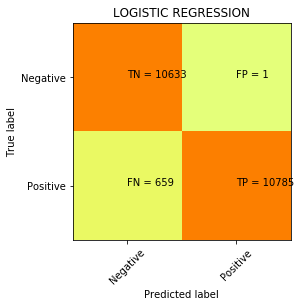

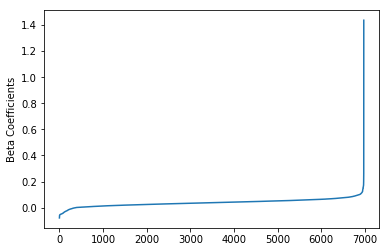

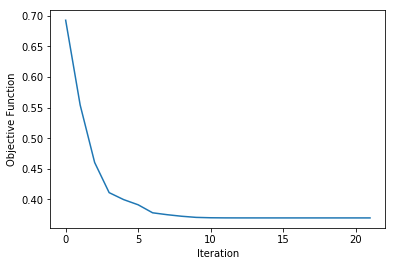

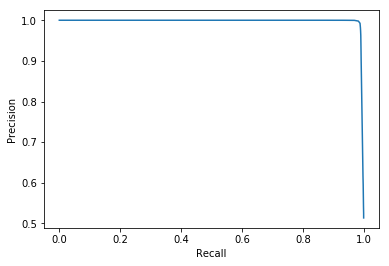

areaUnderROC: 0.9957172909445596


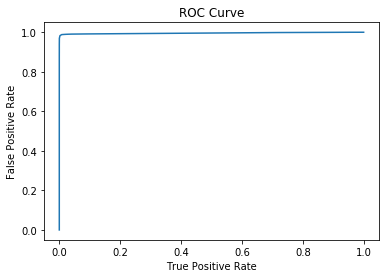

+---------------+---------------+
|      threshold|      F-Measure|
+---------------+---------------+
|0.9999892008...|0.0158754388...|
|0.9918753975...|0.0306486872...|
|0.9856310306...|0.0449095362...|
|0.9807273174...|0.0590895516...|
|0.9758743783...|0.0735549438...|
|0.9712263953...|0.0881679309...|
|0.9671081686...|0.1046162819...|
|0.9634756972...|0.1193857092...|
|0.9595979023...|0.1253142127...|
|0.9577363173...|0.1394217005...|
+---------------+---------------+
only showing top 10 rows



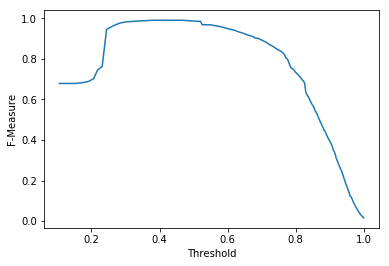

+----------------------------------------+-----+----------+
|                                     url|label|prediction|
+----------------------------------------+-----+----------+
|without-prescription-pharmacy-prices.net|    0|       0.0|
|                    pills-buy-viagra.net|    0|       0.0|
|                    buy-viagra-100mg.net|    0|       0.0|
|               michaelkors-outlet.org.uk|    0|       0.0|
|               levitra-20mg-discount.net|    0|       0.0|
|                  buy-levitra-prices.net|    0|       0.0|
|             michael--kors--outlet.co.uk|    0|       0.0|
|         levitra-vardenafil-generic.mobi|    0|       0.0|
|            buy-doxycycline-hyclate.mobi|    0|       0.0|
|              cheap-viagra-generic.store|    0|       0.0|
+----------------------------------------+-----+----------+
only showing top 10 rows



In [6]:
#==============[ LOGISTIC REGRESSION ]=========================
r = 0.0
p = 0.0
a = 0.0
f1 = 0.0
avg_r = 0.0
avg_p = 0.0
avg_a = 0.0
avg_f1 = 0.0
total_r = 0.0
tofal_p = 0.0
total_a = 0.0
total_f1 = 0.0


# Build logistic regresssion model
for i in range(1,6):
    
    dataset = pipelineFit.transform(sampled)

    #randomly split the dataset to traning and testing 80%, 20% respectively
    #(trainingData, testData) = dataset.randomSplit([0.8, 0.2], seed = 100)
    #print("\n")
    #trainingData.groupby('label').count().toPandas()
    
    lr = LogisticRegression(maxIter=10000, regParam=0.3, elasticNetParam=0, family = "binomial")
    # Train model using logisitic regression
    lrModel = lr.fit(trainingData)

    #Doing the prediction using test data
    #Label is not used in test data
    predictions = lrModel.transform(testData)

      #  predictions.select("url", "label", "prediction").show(n=5, truncate = 100)
    # Select (prediction, true label) and compute test error
    #evaluator = RegressionEvaluator(
     #   labelCol="label", predictionCol="prediction", metricName="rmse")
    #rmse = evaluator.evaluate(predictions)
    #print("\nRoot Mean Squared Error (RMSE) on test data = %g" % rmse)

    # Evaluate model
   # evaluator = BinaryClassificationEvaluator()
    #accuracy = evaluator.evaluate(predictions)
    
    #df = predictions.select('prediction', 'label')

    #tp = df[(df.label == 1) & (df.prediction == 1)].count()
    #tn = df[(df.label == 0) & (df.prediction == 0)].count()
    #fp = df[(df.label == 0) & (df.prediction == 1)].count()
    #fn = df[(df.label == 1) & (df.prediction == 0)].count()
    
    #r = float(tp)/(tp + fn)
    #p = float(tp) / (tp + fp)
    #a = float(tp + tn) / (tp + fp + tn + fn)
    #f1 = float(p*r)/(p+r) * 2
    
    #print("\nAccuracy: %g" %(a*100))
    #print("F-Score: %f1" %(f1*100))
    #print("Recall: %g" %(r*100))
    #print("Precision: %g" %(p*100))
    
    #total_r = total_r + r
    #tofal_p = tofal_p + p
    #total_a = total_a + a
    #total_f1 = total_f1 + f1

#====================================================

#avg_r = total_r/i
#avg_p = tofal_p/i
#avg_a = total_a/i
#avg_f1 = total_f1/i

#print("\nTotal Runs: %i" %i)
#print("Average Accuracy: %g" %(avg_a*100))
#print("Average F-Score: %f1" %(avg_f1*100))
#print("Average Recall: %g" %(avg_r*100))
#print("Average Precision: %g" %(avg_p*100))

df = predictions.select('prediction', 'label')

tp = df[(df.label == 1) & (df.prediction == 1)].count()
tn = df[(df.label == 0) & (df.prediction == 0)].count()
fp = df[(df.label == 0) & (df.prediction == 1)].count()
fn = df[(df.label == 1) & (df.prediction == 0)].count()

print("\nTrue Positives: %g" % tp)
print("True Negative: %g" % tn)
print("False Positive: %g" % fp)
print("False Negative: %g" % fn)

print("Total: %g" % (df.count()))

r = float(tp)/(tp + fn)
p = float(tp) / (tp + fp)
a = float(tp + tn) / (tp + fp + tn + fn)
f1 = float(p*r)/(p+r) * 2


print("\nAccuracy: %g" %(a*100))
print("F-Score: %f1" %(f1*100))
print("Recall: %g" %(r*100))
print("Precision: %g" %(p*100))



#===========================ploting

#plt.clf()
lr_predictions = lrModel.transform(testData)

y_actu = lr_predictions.select("label").toPandas()
y_pred = lr_predictions.select("prediction").toPandas()

cm = confusion_matrix(y_actu, y_pred)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('LOGISTIC REGRESSION')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)

#TN, FP, FN, TP = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()

s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

#===============================================================

beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

# Extract the summary from the returned LogisticRegressionModel instance trained
trainingSummary = lrModel.summary

#Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
plt.plot(objectiveHistory)
plt.ylabel('Objective Function')
plt.xlabel('Iteration')
plt.show()

pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

#Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

#trainingSummary.roc.show(n=10, truncate=15)
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

#Set the model threshold to maximize F-Measure
trainingSummary.fMeasureByThreshold.show(n=10, truncate = 15)
f = trainingSummary.fMeasureByThreshold.toPandas()
plt.plot(f['threshold'],f['F-Measure'])
plt.ylabel('F-Measure')
plt.xlabel('Threshold')
plt.show()

predictions.filter(predictions['prediction'] == 0) \
    .select("url", "label","prediction") \
    .orderBy("probability", ascending=False) \
    .show(n = 10, truncate = 80)
    
#Precision measures the percentage of URLs flagged as malicious that were correctly classified
#Recall measures the percentage of actual Malicious URLs that were correctly classified

# Cross Validation for Logistic Regression

In [7]:
#==============[ Cross Validation for Logistic Regression ]=====================
# Creating ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.3, 0.5]) # regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.2]) # Elastic Net Parameter (Ridge = 0)
#            .addGrid(model.maxIter, [10, 20, 50]) #Number of iterations
#            .addGrid(idf.numFeatures, [10, 100, 1000]) # Number of features
             .build())

# Create 10-fold CrossValidator
cv = CrossValidator(estimator=lr, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=5)

# Run cross validations
cvModel = cv.fit(trainingData)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing

# Use test set here so we can measure the accuracy of our model on new data
predictions = cvModel.transform(testData)

# cvModel uses the best model found from the Cross Validation
# Evaluate best model
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

#================================================================
df = predictions.select('prediction', 'label')

predictionAndLabels=df.rdd
metrics = MulticlassMetrics(predictionAndLabels) 



tp = df[(df.label == 1) & (df.prediction == 1)].count()
tn = df[(df.label == 0) & (df.prediction == 0)].count()
fp = df[(df.label == 0) & (df.prediction == 1)].count()
fn = df[(df.label == 1) & (df.prediction == 0)].count()

print("\nTrue Positives: %g" % tp)
print("True Negative: %g" % tn)
print("False Positive: %g" % fp)
print("False Negative: %g" % fn)


print("Total: %g" % (df.count()))

r = float(tp)/(tp + fn)
p = float(tp) / (tp + fp)
a = float(tp + tn) / (tp + fp + tn + fn)
f1 = float(p*r)/(p+r) * 2
print("F-Score: %f1" %(f1*100))

print("\nAccuracy: %g" %(a*100))
print("Recall: %g" %(r*100))
print("Precision: %g" %(p*100))


#=============================================================

cv_predictions = cvModel.transform(testData)

y_actu = cv_predictions.select("label").toPandas()
y_pred = cv_predictions.select("prediction").toPandas()

cm = confusion_matrix(y_actu, y_pred)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('CROSS-VALIDATION FOR LOGISTIC REGRESSION')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)


s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

NameError: name 'evaluator' is not defined

# Naive Bayes

In [ ]:

# create the trainer and set its parameters
nb = NaiveBayes(smoothing=1, modelType="multinomial",)

# train the model
model = nb.fit(trainingData)

# select example rows to display.
predictions = model.transform(testData)


# compute accuracy on the test set
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
print("Test: Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

#===========================
df = predictions.select('prediction', 'label')

tp = df[(df.label == 1) & (df.prediction == 1)].count()
tn = df[(df.label == 0) & (df.prediction == 0)].count()
fp = df[(df.label == 0) & (df.prediction == 1)].count()
fn = df[(df.label == 1) & (df.prediction == 0)].count()

print("True Positives: %g" % tp)
print("True Negative: %g" % tn)
print("False Positive: %g" % fp)
print("False Negative: %g" % fn)

print("Total: %g" % (df.count()))

r = float(tp)/(tp + fn)
p = float(tp) / (tp + fp)
a = float(tp + tn) / (tp + fp + tn + fn)
f1 = float(p*r)/(p+r) * 2
print("F-Score: %f1" %(f1*100))

print("\nAccuracy: %g" %(a*100))
print("Recall: %g" %(r*100))
print("Precision: %g" %(p*100))


#===========================ploting

#plt.clf()
nb_predictions = model.transform(testData)

y_actu = nb_predictions.select("label").toPandas()
y_pred = nb_predictions.select("prediction").toPandas()

cm = confusion_matrix(y_actu, y_pred)

plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Naive Bayes')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)

#TN, FP, FN, TP = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()

s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

# Linear Support Vector Machine

In [ ]:
#==============[ Linear Support Vector Machine ]=====================

for i in range(1, 2):
    

    lsvc = LinearSVC(maxIter=10, regParam=0.3)

    # Fit the model
    lsvcModel = lsvc.fit(trainingData)

    predictions = lsvcModel.transform(testData)

    #predictions.select("url", "label", "prediction").show(n=5, truncate = 100)

    # Select (prediction, true label) and compute test error
    evaluator = RegressionEvaluator(
        labelCol="label", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)
    print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

    # Evaluate model
    evaluator = BinaryClassificationEvaluator()
    accuracy = evaluator.evaluate(predictions)

    
    #================================================================
    df = predictions.select('prediction', 'label')
    predictionAndLabels=df.rdd

    metrics = MulticlassMetrics(predictionAndLabels) 

    

    tp = df[(df.label == 1) & (df.prediction == 1)].count()
    tn = df[(df.label == 0) & (df.prediction == 0)].count()
    fp = df[(df.label == 0) & (df.prediction == 1)].count()
    fn = df[(df.label == 1) & (df.prediction == 0)].count()

    print("True Positives: %g" % tp)
    print("True Negative: %g" % tn)
    print("False Positive: %g" % fp)
    print("False Negative: %g" % fn)

    print("Total: %g" % (df.count()))

    r = float(tp)/(tp + fn)
    p = float(tp) / (tp + fp)
    a = float(tp + tn) / (tp + fp + tn + fn)
    f1 = float(p*r)/(p+r) * 2
    print("F-Score: %f1" %(f1*100))
    
    print("\nAccuracy: %g" %(a*100))
    print("Recall: %g" %(r*100))
    print("Precision: %g" %(p*100))
  

#=============================================================
    
    #==================[ Confusing Matrix Calculation and Plotting ]
    lsvm_predictions = lsvcModel.transform(testData)


    y_actu = lsvm_predictions.select("label").toPandas()
    y_pred = lsvm_predictions.select("prediction").toPandas()

    cm = confusion_matrix(y_actu, y_pred)

    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    plt.title('LINEAR SUPPORT VECTOR MACHINE')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)

    #TN, FP, FN, TP = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()

    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()
    

# One-vs-Rest Classifier ( a.k.a One-vs-All )

In [ ]:
#==============[ One-vs-Rest classifier (a.k.a. One-vs-All ]=====================

for i in range(1, 2):
    
    # instantiate the base classifier.
    #lr = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)
    lr = LogisticRegression(maxIter=10, regParam=0.001, elasticNetParam=0, tol=1E-6, fitIntercept=True )

    # instantiate the One Vs Rest Classifier.
    ovr = OneVsRest(classifier=lr)

    # train the multiclass model.
    ovrModel = ovr.fit(trainingData)

    # score the model on test data.
    predictions = ovrModel.transform(testData)

    # obtain evaluator.
    evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

    # compute the classification error on test data.
    accuracy = evaluator.evaluate(predictions)
    print("Test Error = %g" % (1.0 - accuracy))
    print("\nAccuracy on Test Data = %g" % (accuracy*100))
    
    #evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", metricName="accuracy")
    #accuracy = evaluator.evaluate(predictions)
    #print("Accuracy = %g" % (accuracy*100))

    #evaluatorf1 = MulticlassClassificationEvaluator( predictionCol="prediction", metricName="f1")
    #f1 = evaluatorf1.evaluate(predictions)
    #print("f1 = %g" % (f1*100))
 
    #================================================================
    df = predictions.select('prediction', 'label')

    tp = df[(df.label == 1) & (df.prediction == 1)].count()
    tn = df[(df.label == 0) & (df.prediction == 0)].count()
    fp = df[(df.label == 0) & (df.prediction == 1)].count()
    fn = df[(df.label == 1) & (df.prediction == 0)].count()

    print("True Positives: %g" % tp)
    print("True Negative: %g" % tn)
    print("False Positive: %g" % fp)
    print("False Negative: %g" % fn)

    print("Total: %g" % (df.count()))

    r = float(tp)/(tp + fn)
    p = float(tp) / (tp + fp)
    a = float(tp + tn) / (tp + fp + tn + fn)
    f1 = float(p*r)/(p+r) * 2
    print("F-Score: %f1" %(f1*100))
    print("Recal: %g" %(r*100))
    print("Precision: %g" %(p*100))
    print("Accuracy: %g" %(a*100))
    
    
             
               
#=============================================================
    
    ovr_predictions = ovrModel.transform(testData)

    y_actu = ovr_predictions.select("label").toPandas()
    y_pred = ovr_predictions.select("prediction").toPandas()

    cm = confusion_matrix(y_actu, y_pred)

    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    plt.title('ONE-VS-RES CLASSIFIER (A.K.A ONE-VS-ALL)')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)

    #TN, FP, FN, TP = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()

    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()
    

In [10]:
from pyspark.ml.feature import CountVectorizer

# Input data: Each row is a bag of words with a ID.

df = spark.createDataFrame([
    (0, "a b c".split(" ")),
    (1, "a b b c a".split(" "))
], ["id", "words"])

# fit a CountVectorizerModel from the corpus.
cv = CountVectorizer(inputCol="words", outputCol="rawFeatures", vocabSize=3, minDF=2.0)

#


#rescaledData = idfModel.transform(cv)

model = cv.fit(df)
result = model.transform(df)

idf = IDF(inputCol="rawFeatures", outputCol="features")

idfModel = idf.fit(result)

rescaledData = idfModel.transform(result)





result.show(truncate=False)

rescaledData.show(truncate=False)

+---+---------------+-------------------------+
|id |words          |rawFeatures              |
+---+---------------+-------------------------+
|0  |[a, b, c]      |(3,[0,1,2],[1.0,1.0,1.0])|
|1  |[a, b, b, c, a]|(3,[0,1,2],[2.0,2.0,1.0])|
+---+---------------+-------------------------+

+---+---------------+-------------------------+-------------------------+
|id |words          |rawFeatures              |features                 |
+---+---------------+-------------------------+-------------------------+
|0  |[a, b, c]      |(3,[0,1,2],[1.0,1.0,1.0])|(3,[0,1,2],[0.0,0.0,0.0])|
|1  |[a, b, b, c, a]|(3,[0,1,2],[2.0,2.0,1.0])|(3,[0,1,2],[0.0,0.0,0.0])|
+---+---------------+-------------------------+-------------------------+



In [11]:
dataset.show(5)

+--------------------+-----+--------------------+--------------------+--------------------+
|                 url|label|               Words|         rawfeatures|            features|
+--------------------+-----+--------------------+--------------------+--------------------+
|http://br-ofertas...|    1|[http, br, oferta...|(6976,[0,1,2,3,19...|(6976,[0,1,2,3,19...|
|https://semana-da...|    1|[https, semana, d...|(6976,[0,3,6,19,2...|(6976,[0,3,6,19,2...|
|https://scrid-app...|    1|[https, scrid, ap...|(6976,[0,6,829],[...|(6976,[0,6,829],[...|
|http://my-softban...|    1|[http, my, softba...|(6976,[0,1,28,164...|(6976,[0,1,28,164...|
|http://www.my-sof...|    1|[http, www, my, s...|(6976,[0,1,4,28,1...|(6976,[0,1,4,28,1...|
+--------------------+-----+--------------------+--------------------+--------------------+
only showing top 5 rows

